# May ?th, 2021

**Motivation**: CCA between hemispheres. </br>

In [1]:
# HIDE CODE


import re
import os
import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from os.path import join as pjoin
from scipy import stats as sp_stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from utils.plotting import *
from utils.processing import *
from model.configuration import Config

In [2]:
# HIDE CODE


def filter_islands(partition, atlas, node_labels, min_com_size: int = 3):
    coms_ctr = collections.Counter(partition.values())
    
    good_com_idxs = zip(*filter(lambda x: x[1] > min_com_size, coms_ctr.most_common()))
    good_com_idxs = sorted(tuple(good_com_idxs)[0])
    bad_com_idxs = [item for item in set(partition.values()) if item not in good_com_idxs]

    comm_dict = collections.defaultdict(list)
    for k, v in partition.items():
        comm_dict[v].append(k)
    comm_dict = dict(sorted(comm_dict.items()))

    comm_mat = np.ones(atlas.shape) * -1
    for node, com_idx in partition.items():
        region_id = node_labels[node]
        if com_idx in good_com_idxs:
            comm_mat[atlas == region_id] = good_com_idxs.index(com_idx)
        else:
            comm_mat[atlas == region_id] = np.nan
    
    output = {
        'good_com_idxs': good_com_idxs,
        'bad_com_idxs': bad_com_idxs,
        'comm_dict': comm_dict,
        'comm_mat': comm_mat,
    }
    return output


def plot_louvain_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    contour: np.ndarray,
    modularities: dict,
    selected_idxs: list,
    pearson_th: float = 0.8,
    spearman_th: float = 0.7,
    figsize=(12, 4.5),
    colorbar=False, ):

    x0, y0 = tuple(zip(*modularities.items()))
    best_idx = np.argmax(y0)
    best_res = x0[best_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [best_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        # pearson
        g = nx.from_numpy_matrix(pearson[pearson_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)

        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[0, ii].imshow(data2plot, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[0, ii].set_title(msg, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[spearman_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)
    
        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[1, ii].imshow(data2plot, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[1, ii].set_title(msg, y=1.03)
        

        if ii == 0:
            axes[0, ii].set_ylabel('pearson\n(th = {:.2f})\n'.format(pearson_th), fontsize=12)
            axes[1, ii].set_ylabel('spearman\n(th = {:.2f})\n'.format(spearman_th), fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



def plot_leiden_communities(pearson, spearman, atlas, figsize=None, colorbar=False):
    thresholds = list(spearman.keys())
    
    sns.set_style('white')
    figsize = (5.2, 2*len(thresholds)) if figsize is None else figsize
    fig, axes = plt.subplots(len(thresholds), 2, figsize=figsize)

    for ii, th in enumerate(sorted(thresholds, reverse=True)):
        # pearson
        g = nx.from_numpy_matrix(pearson[th])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)

        im = axes[ii, 0].imshow(output['comm_mat'], cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 0], shrink=0.9)
        if ii == 0:
            msg = 'Pearson\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 0].set_title(msg, fontsize=10, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[th])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)
        
        im = axes[ii, 1].imshow(output['comm_mat'], cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 1], shrink=0.9)
        if ii == 0:
            msg = 'Spearman\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 1].set_title(msg, fontsize=10, y=1.03)
        axes[ii, 1].set_ylabel('th = {:.2f}\n'.format(th), fontsize=10)
        
        for j in range(2):
            axes[ii, j].set_xticks([])
            axes[ii, j].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



from skimage.feature import canny
import functools


def organize_atlas(organized_data: dict, include: List = None, config: Config = None):
    config = Config() if config is None else config
    regions = np.unique(organized_data['atlas'])
    regions = {i: config.region_labels[i] for i in regions if i > 0}
    
    include = [i for i in regions if i < 24] if include is None else include
    exclude = [item for item in regions if item not in include]
    mapping = {i+1: regions[item].split('(')[0].strip() for i, item in enumerate(include)}

    atlas = organized_data['atlas'].copy().astype(float)
    cond = functools.reduce(np.logical_or, [atlas == r for r in exclude])
    x = np.ma.masked_where(cond, atlas)

    for i, true_i in zip(mapping, include):
        x[x == true_i] = i

    mapping[0] = 'background'
    mapping = dict(sorted(mapping.items()))

    contour = atlas.copy()
    for i, true_i in enumerate(regions):
        contour[contour == true_i] = i
    contour = canny(contour, sigma=1e-10)
    y = np.ma.masked_where(contour, x)

    output = {
        'regions': regions,
        'mapping': mapping,
        'atlas_limited': x,
        'contour': contour,
        'atlas_masked': y,
    }
    return output

## Allen atlas visualization

In [6]:
config = Config()

num_regions = 256
subject = 6
session = 1
run = 1

load = load_organized_data(
    folder='atlas-allen_unfiltered_unnormalized',
    config=config,
    subject=subject,
    session=session,
    run=run,
)

In [7]:
atls_org = organize_atlas(load)

In [319]:
data_all = {}
df = pd.DataFrame()

subject = 6
for session in [1, 2, 3]:
    for run in [1, 3, 5, 7]:
        _load = load_organized_data(
            folder='atlas-allen_unfiltered_unnormalized',
            config=config,
            subject=subject,
            session=session,
            run=run,
        )
        data_all[run] = _load

        # normalize
        mean = np.mean([item.mean() for item in _load['ca'].values()])
        sd = np.mean([item.std() for item in _load['ca'].values()])
        _ca = {k: (v - mean) / sd for k, v in _load['ca'].items()}
        _df = pd.DataFrame.from_dict(_ca)
        df = pd.concat([df, _df])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df.describe()

,2,3,4,5,6,7,8,9,10,11,...,526,528,530,538,539,540,541,655,656,721
count,66000.000000,66000.000000,66000.000000,66000.000000,66000.000000,66000.000000,66000.000000,66000.000000,66000.000000,66000.000000,...,66000.000000,66000.000000,66000.000000,66000.000000,66000.000000,66000.000000,66000.000000,66000.000000,66000.000000,22000.000000
mean,0.020701,0.030195,0.005908,-0.021003,0.009913,0.023958,0.006035,-0.006444,-0.009444,0.006751,...,-0.026358,0.050541,0.055375,-0.040011,-0.026465,0.002515,-0.004228,0.035160,0.022351,0.025647
std,0.613763,0.460314,0.650838,1.159804,1.215081,0.455112,0.940438,1.772659,1.064983,0.770235,...,1.175537,0.378528,0.253251,1.901365,2.207547,1.484504,0.631852,0.805106,0.730405,0.607880
min,-2.731128,-2.002298,-2.548322,-4.818682,-4.713502,-2.045065,-3.699036,-6.521820,-4.100632,-3.348027,...,-5.081031,-1.742169,-0.802943,-8.277740,-9.487407,-7.463956,-3.737151,-4.471918,-4.565433,-2.803750
25%,-0.380693,-0.261311,-0.440862,-0.812835,-0.814548,-0.286172,-0.636872,-1.217696,-0.741436,-0.510380,...,-0.816888,-0.187728,-0.125743,-1.181148,-1.443048,-0.893065,-0.395033,-0.468668,-0.428682,-0.370451
50%,0.037384,0.039159,-0.008861,-0.034086,-0.002114,0.014922,-0.008713,-0.045743,-0.029609,-0.006579,...,-0.017255,0.048899,0.034885,0.105767,0.091922,0.034815,0.007985,0.071374,0.047160,0.039969
75%,0.435655,0.332594,0.437815,0.754084,0.825077,0.326929,0.639066,1.164309,0.708248,0.510164,...,0.778471,0.293636,0.206260,1.244154,1.412762,0.876222,0.404516,0.553107,0.501993,0.436231
max,3.802673,3.315142,3.156683,6.369267,7.755381,1.907196,4.785238,10.427175,5.674547,4.721781,...,5.843461,5.597064,1.116010,12.347784,16.508649,19.975790,3.060861,11.461152,6.242416,3.080807


In [320]:
null_columns = df.isnull().sum()
null_columns = null_columns[null_columns > 0].index.tolist()
df_clean = df.drop(null_columns, axis=1)

In [321]:
thresholds = [0.75, 0.78, 0.79, 0.80, 0.81, 0.82]
corrs = get_corrs(df_clean, thresholds=thresholds)

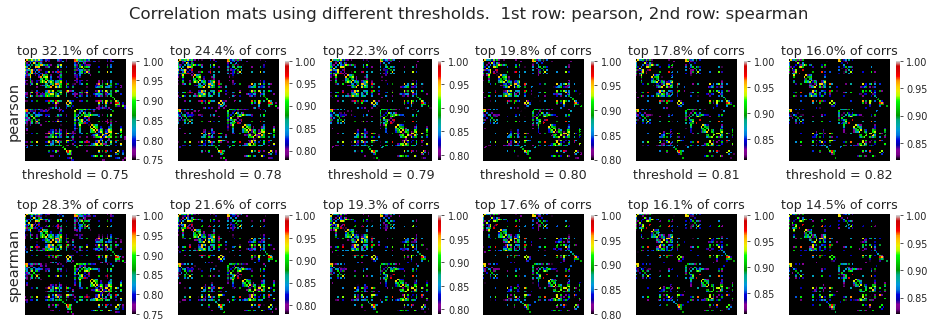

In [322]:
_ = plot_corrs(corrs['pearson'], corrs['spearman'])

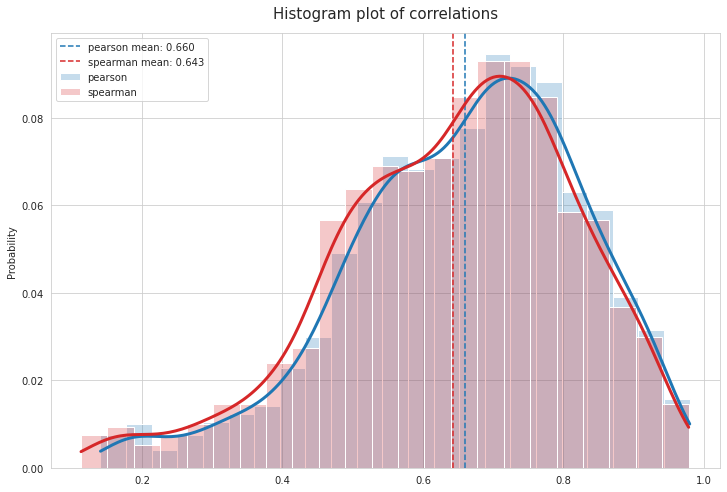

In [323]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
)

In [324]:
from sklearn.preprocessing import normalize
from scipy.linalg import svd, sqrtm, inv
from scipy.stats import zscore
from numpy.linalg import norm


def cov(X, Y, bias: bool = True):
    mu_X = X.mean(0, keepdims=True)
    mu_Y = Y.mean(0, keepdims=True)
    if bias:
        return (X.T @ Y - mu_X.T @ mu_Y) / (len(X) - 1)
    else:
        return X.T @ Y - mu_X.T @ mu_Y


def uniform_zscore(x_trn, x_tst, axis=0):
    mean = x_trn.mean(0)
    sd = x_trn.std(0)
    
    return ((x_trn - mean) / sd, (x_tst - mean) / sd) 


def do_cca(data_trn, data_tst):
    Xa_trn, Xb_trn = [item.reshape(-1, item.shape[-1])
                      for item in data_trn['cat'].values()]
    Xa_tst, Xb_tst = [item.reshape(-1, item.shape[-1])
                      for item in data_tst['cat'].values()]

    Xa_trn, Xa_tst = uniform_zscore(Xa_trn, Xa_tst)
    Xb_trn, Xb_tst = uniform_zscore(Xb_trn, Xb_tst)
    
    Caa = cov(Xa_trn, Xa_trn, True)
    Cab = cov(Xa_trn, Xb_trn, True)
    Cbb = cov(Xb_trn, Xb_trn, True)
    
    M = inv(sqrtm(Caa)) @ Cab @ sqrtm(Cbb)
    U, S, Vh = svd(M, full_matrices=False, lapack_driver='gesvd')
    max_num_ccs = min([item.shape[-1] for item in data_trn['cat'].values()])
    
    Wa = inv(sqrtm(Caa)) @ U
    Wb = inv(sqrtm(Cbb)) @ Vh.T
    # Wa = Wa[:, :max_num_ccs]
    # Wb = Wb[:, :max_num_ccs]
    
    # Za_trn, Za_tst = Xa_trn @ Wa / np.sqrt(len(Xa_trn) - 1), Xa_tst @ Wa / np.sqrt(len(Xa_tst) - 1)
    # Zb_trn, Zb_tst = Xb_trn @ Wb / np.sqrt(len(Xb_trn) - 1), Xb_tst @ Wb / np.sqrt(len(Xb_tst) - 1)
    
    Za_trn, Za_tst = Xa_trn @ Wa, Xa_tst @ Wa
    Zb_trn, Zb_tst = Xb_trn @ Wb, Xb_tst @ Wb

    x_a_trn = Xa_trn.reshape(len(trange), -1, Xa_trn.shape[-1])
    x_b_trn = Xb_trn.reshape(len(trange), -1, Xb_trn.shape[-1])
    x_a_tst = Xa_tst.reshape(len(trange), -1, Xa_tst.shape[-1])
    x_b_tst = Xb_tst.reshape(len(trange), -1, Xb_tst.shape[-1])

    x_cca_trn = np.concatenate(
        [Za_trn.reshape(len(trange), -1, max_num_ccs),
         Zb_trn.reshape(len(trange), -1, max_num_ccs)], axis=1)
    x_cca_tst = np.concatenate(
        [Za_tst.reshape(len(trange), -1, max_num_ccs),
         Zb_tst.reshape(len(trange), -1, max_num_ccs)], axis=1)

    num_trn, num_tst = len(data_trn['y']), len(data_tst['y'])

    y_a_trn = data_trn['y'][:num_trn//2]
    y_b_trn = data_trn['y'][num_trn//2:]
    y_a_tst = data_tst['y'][:num_tst//2]
    y_b_tst = data_tst['y'][num_tst//2:]

    y_cca_trn = data_trn['y']
    y_cca_tst = data_tst['y']
    
    output_cca = {
        'wa': Wa,
        'wb': Wb,
        'x_trn': x_cca_trn,
        'x_tst': x_cca_tst,
        'y_trn': y_cca_trn,
        'y_tst': y_cca_tst,
        'za_trn': Za_trn,
        'za_tst': Za_tst,
        'zb_trn': Zb_trn,
        'zb_tst': Zb_tst,
    }
    output_a = {
        'x_trn': x_a_trn,
        'x_tst': x_a_tst,
        'y_trn': y_a_trn,
        'y_tst': y_a_tst,
    }
    output_b = {
        'x_trn': x_b_trn,
        'x_tst': x_b_tst,
        'y_trn': y_b_trn,
        'y_tst': y_b_tst,
    }
    return output_cca, output_a, output_b

In [326]:
df_clean.columns

Int64Index([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  14,  15,  16,
             18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  30,  38,  39,
             40, 155, 156, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511,
            514, 515, 516, 518, 519, 520, 521, 522, 523, 524, 525, 526, 528,
            530, 538, 539, 540, 541, 655, 656],
           dtype='int64')

In [328]:
regions_r = {k: v[2:].strip() for k, v in atls_org['regions'].items() if 'R-' in v and k in df_clean.columns}
regions_l = {k: v[2:].strip() for k, v in atls_org['regions'].items() if 'L-' in v and k in df_clean.columns}

shared_regions = set(regions_r.values()).intersection(set(regions_l.values()))
regions_r = {k: v for k, v in regions_r.items() if v in shared_regions}
regions_l = {k: v for k, v in regions_l.items() if v in shared_regions}

len(regions_r), len(regions_l), len(shared_regions)

(29, 29, 29)

In [331]:
df_r = df_clean.loc[:, regions_r.keys()]
df_l = df_clean.loc[:, regions_l.keys()]

df_r.shape, df_l.shape

((66000, 29), (66000, 29))

In [333]:
x_r = df_r.values.copy()
x_l = df_l.values.copy()
x_r_norm = sp_stats.zscore(x_r, axis=0)
x_l_norm = sp_stats.zscore(x_l, axis=0)

x_r.shape, x_l.shape

((66000, 29), (66000, 29))

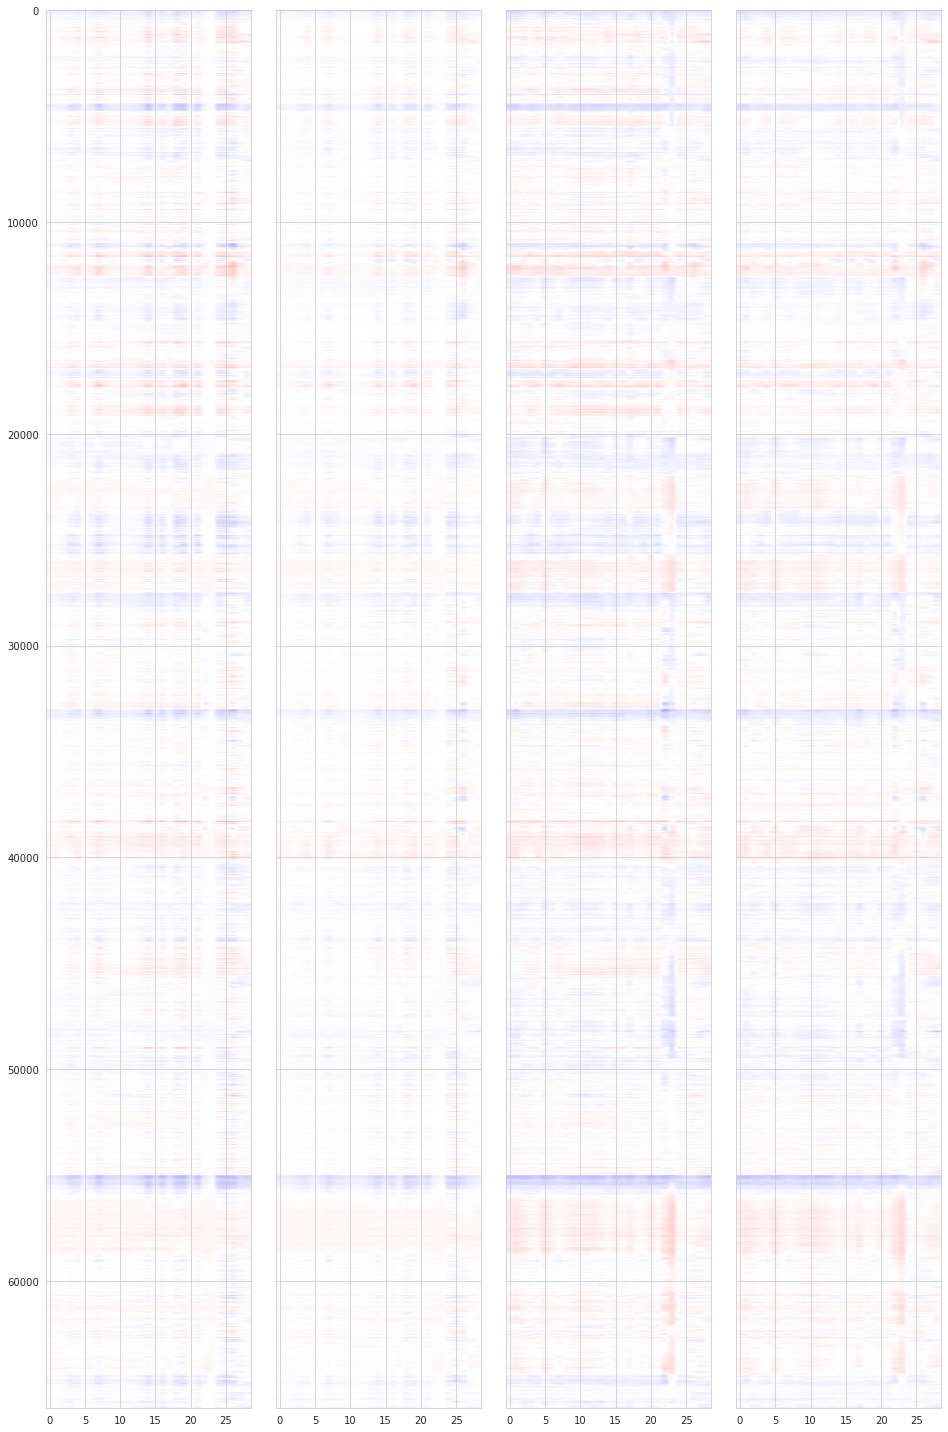

In [337]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 4, figsize=(13.5, 20), sharey='all')

aspect = 0.003

vminmax = np.max(np.abs(x_r))
axes[0].imshow(x_r, aspect=aspect, cmap='bwr', vmin=-vminmax, vmax=vminmax)

vminmax = np.max(np.abs(x_l))
axes[1].imshow(x_l, aspect=aspect, cmap='bwr', vmin=-vminmax, vmax=vminmax)

vminmax = np.max(np.abs(x_r_norm))
axes[2].imshow(x_r_norm, aspect=aspect, cmap='bwr', vmin=-vminmax, vmax=vminmax)

vminmax = np.max(np.abs(x_l_norm))
axes[3].imshow(x_l_norm, aspect=aspect, cmap='bwr', vmin=-vminmax, vmax=vminmax)

fig.tight_layout()

In [338]:
xv_folds = 10

nt = len(x_r) // 4

trn_ids = []
for i in range(4):
    start = i * nt
    end = (i+1) * nt - nt // xv_folds
    trn_ids.extend(range(start, end))
trn_ids = np.array(trn_ids)
tst_ids = np.delete(range(len(x_r)), trn_ids)

assert not set(trn_ids).intersection(tst_ids)
len(trn_ids), len(tst_ids)

(59400, 6600)

In [339]:
from sklearn.preprocessing import normalize
from scipy.linalg import svd, sqrtm, inv
from scipy.stats import zscore
from numpy.linalg import norm


def cov(X, Y, bias: bool = True):
    mu_X = X.mean(0, keepdims=True)
    mu_Y = Y.mean(0, keepdims=True)
    if bias:
        return (X.T @ Y - mu_X.T @ mu_Y) / (len(X) - 1)
    else:
        return X.T @ Y - mu_X.T @ mu_Y


def do_cca(Xa_trn, Xb_trn, Xa_tst, Xb_tst):
    Caa = cov(Xa_trn, Xa_trn, True)
    Cab = cov(Xa_trn, Xb_trn, True)
    Cbb = cov(Xb_trn, Xb_trn, True)
    
    M = inv(sqrtm(Caa)) @ Cab @ sqrtm(Cbb)
    U, S, Vh = svd(M, full_matrices=False, lapack_driver='gesvd')
    # max_num_ccs = min([item.shape[-1] for item in data_trn['cat'].values()])
    
    Wa = inv(sqrtm(Caa)) @ U
    Wb = inv(sqrtm(Cbb)) @ Vh.T
    # Wa = Wa[:, :max_num_ccs]
    # Wb = Wb[:, :max_num_ccs]
    
    # Za_trn, Za_tst = Xa_trn @ Wa / np.sqrt(len(Xa_trn) - 1), Xa_tst @ Wa / np.sqrt(len(Xa_tst) - 1)
    # Zb_trn, Zb_tst = Xb_trn @ Wb / np.sqrt(len(Xb_trn) - 1), Xb_tst @ Wb / np.sqrt(len(Xb_tst) - 1)
    
    Za_trn, Za_tst = Xa_trn @ Wa, Xa_tst @ Wa
    Zb_trn, Zb_tst = Xb_trn @ Wb, Xb_tst @ Wb
    
    output_cca = {
        'S': S,
        'wa': Wa,
        'wb': Wb,

        'za_trn': Za_trn,
        'za_tst': Za_tst,
        'zb_trn': Zb_trn,
        'zb_tst': Zb_tst,
    }
    return output_cca#, output_a, output_b

In [340]:
output = do_cca(x_r_norm[trn_ids], x_l_norm[trn_ids], x_r_norm[tst_ids], x_l_norm[tst_ids])

In [341]:
output.keys()

dict_keys(['S', 'wa', 'wb', 'za_trn', 'za_tst', 'zb_trn', 'zb_tst'])

In [342]:
output['wa'].shape

(29, 29)

In [343]:
output['wb'].shape

(29, 29)

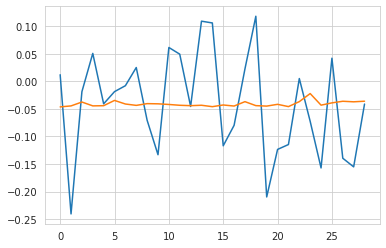

In [344]:
plt.plot(output['wa'][:, 0])
plt.plot(output['wb'][:, 0])

In [345]:
from sklearn.metrics.pairwise import cosine_similarity

In [348]:
cos_sim = cosine_similarity(output['wa'][:, :25].T, output['wb'][:, :25].T)
cos_sim.shape

(25, 25)

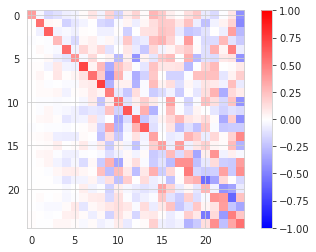

In [349]:
plt.imshow(cos_sim, vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()

In [350]:
output['za_trn'].shape

(59400, 29)

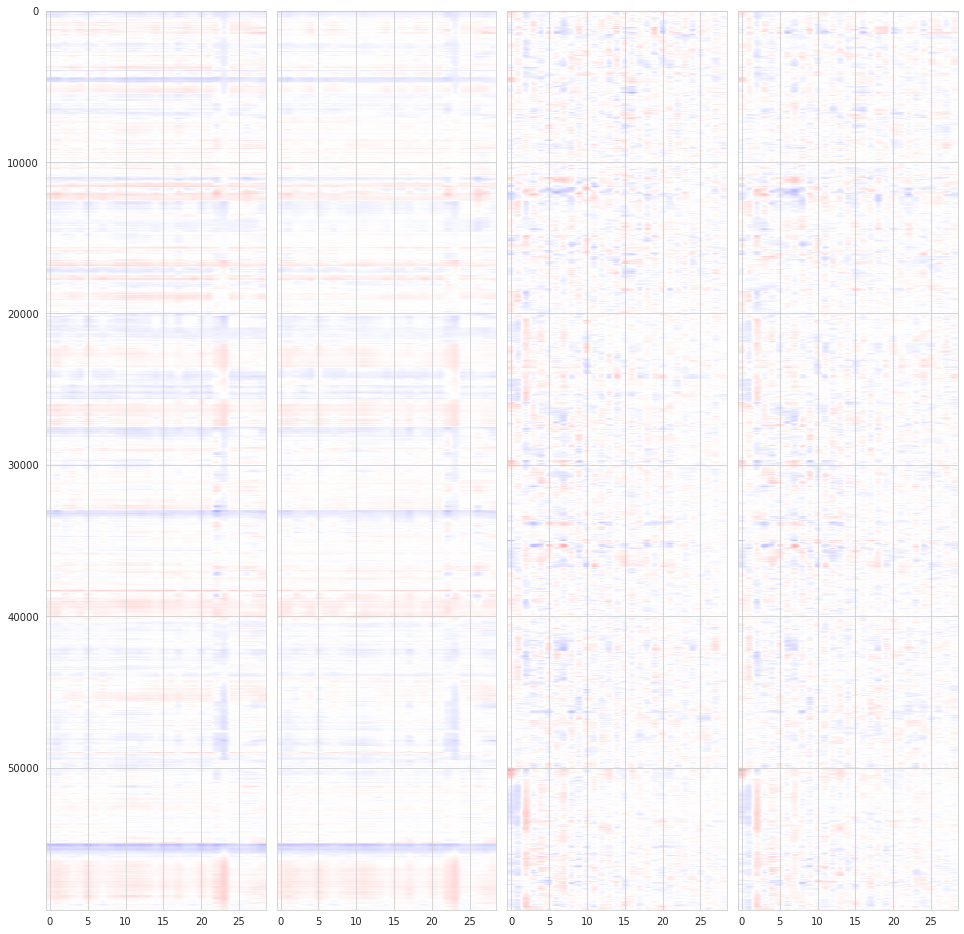

In [351]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 4, figsize=(13.5, 20), sharey='all')

aspect = 0.002

vminmax = np.max(np.abs(x_r_norm))
axes[0].imshow(x_r_norm, aspect=aspect, cmap='bwr', vmin=-vminmax, vmax=vminmax)

vminmax = np.max(np.abs(x_l_norm))
axes[1].imshow(x_l_norm, aspect=aspect, cmap='bwr', vmin=-vminmax, vmax=vminmax)

vminmax = np.max(np.abs(output['za_trn']))
axes[2].imshow(output['za_trn'], aspect=aspect, cmap='bwr', vmin=-vminmax, vmax=vminmax)

vminmax = np.max(np.abs(output['zb_trn']))
axes[3].imshow(output['zb_trn'], aspect=aspect, cmap='bwr', vmin=-vminmax, vmax=vminmax)

fig.tight_layout()

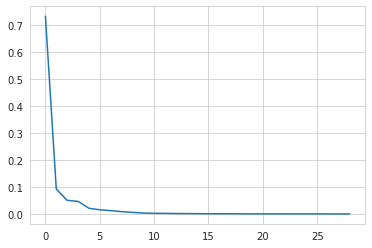

In [352]:
plt.plot(output['S'] / sum(output['S']))
#plt.yscale('log')

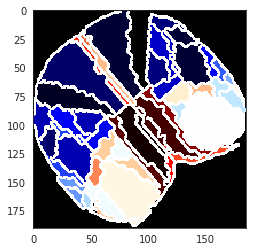

In [353]:
sns.set_style('white')
atlas = np.ma.masked_where(atls_org['contour'], load['atlas'])
plt.imshow(atlas, cmap='flag_r')

In [354]:
from sklearn.preprocessing import normalize as sk_normalize

-3.119511354213465e-17 0.9999999999999998 1.217416971830344e-15 1.0


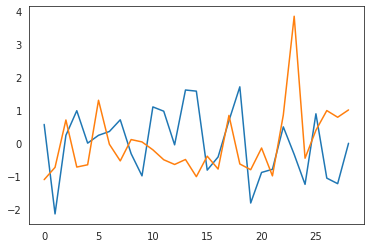

-3.254101968728907e-17 1.0 3.828355257328126e-18 1.0


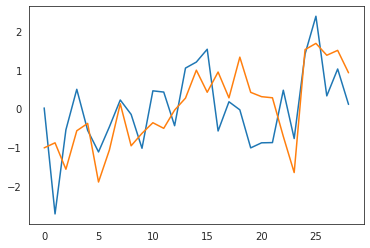

-2.584139798696485e-17 0.9999999999999999 6.125368411725002e-17 0.9999999999999999


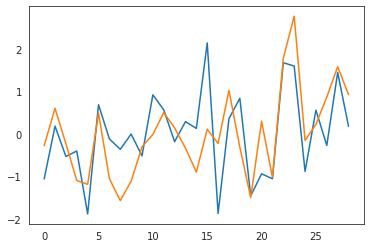

-3.828355257328126e-17 1.0 -2.2970131543968756e-17 1.0


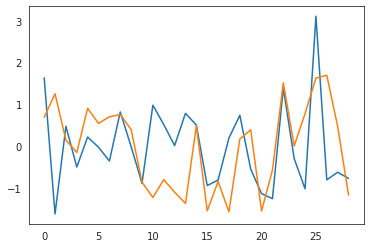

-1.7227598657976568e-17 1.0 7.656710514656252e-18 1.0


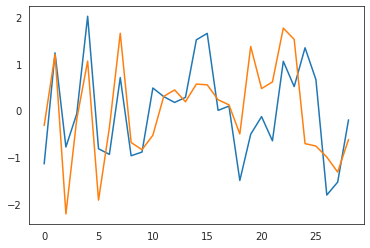

-7.656710514656252e-18 1.0 3.062684205862501e-17 1.0


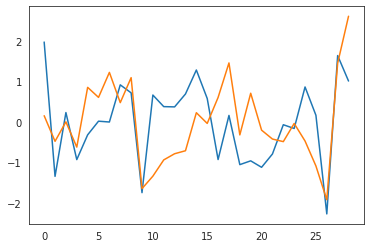

-1.7227598657976568e-17 1.0 2.2970131543968756e-17 1.0


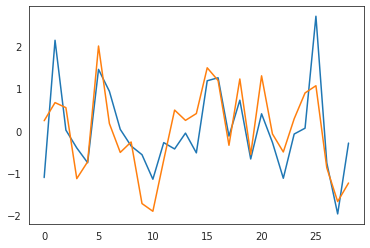

-2.6798486801296883e-17 0.9999999999999999 -3.062684205862501e-17 1.0


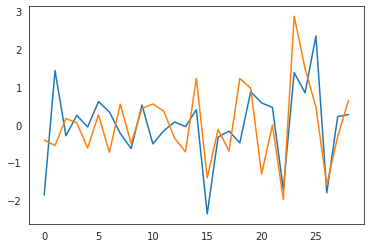

1.914177628664063e-18 1.0 1.914177628664063e-17 1.0


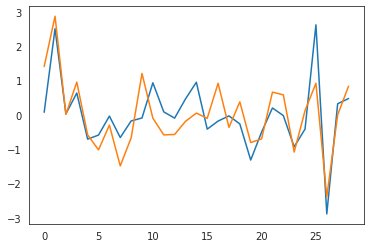

-2.2970131543968756e-17 0.9999999999999999 3.828355257328126e-18 0.9999999999999999


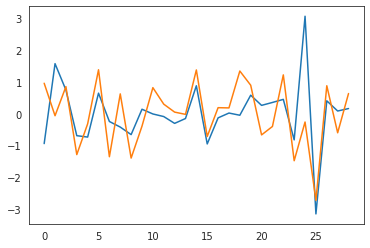

7.656710514656252e-18 1.0 1.4834876622146487e-17 0.9999999999999999


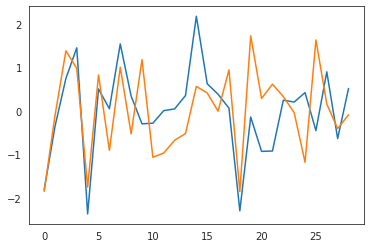

-1.5313421029312504e-17 1.0 -2.2970131543968756e-17 1.0


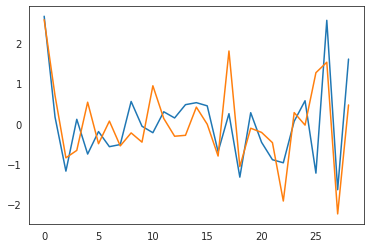

-3.828355257328126e-18 0.9999999999999999 4.594026308793751e-17 0.9999999999999998


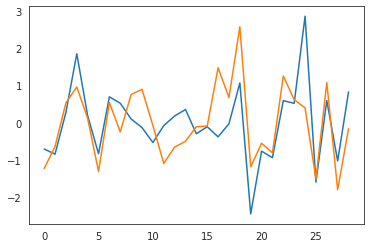

2.6798486801296883e-17 0.9999999999999999 -3.924064138761329e-17 1.0


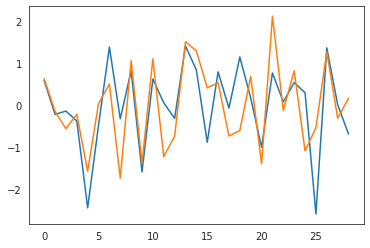

-1.1485065771984378e-17 1.0000000000000002 -2.871266442996095e-17 1.0


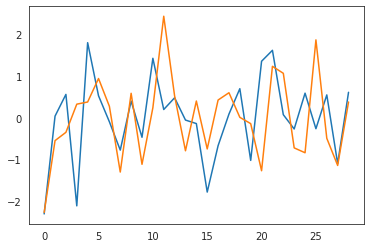

1.1485065771984378e-17 1.0 2.871266442996095e-17 0.9999999999999999


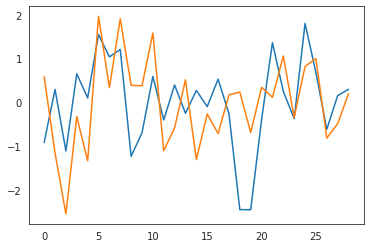

7.656710514656252e-18 1.0000000000000002 0.0 0.9999999999999999


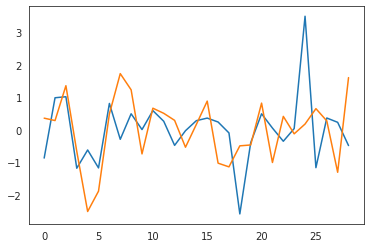

1.914177628664063e-17 1.0 1.5313421029312504e-17 1.0


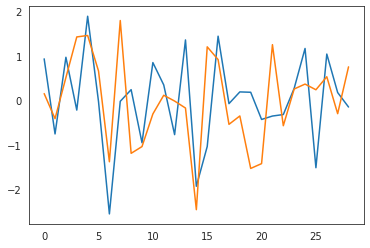

2.2970131543968756e-17 0.9999999999999999 -7.656710514656252e-18 0.9999999999999999


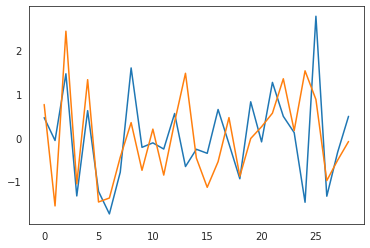

-2.7277031208462897e-17 1.0 2.2970131543968756e-17 1.0


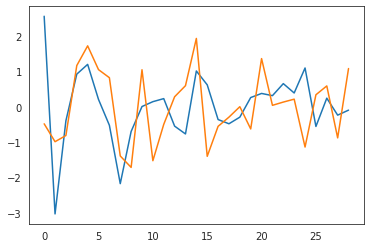

-2.3927220358300786e-17 0.9999999999999998 1.6270509843644534e-17 0.9999999999999998


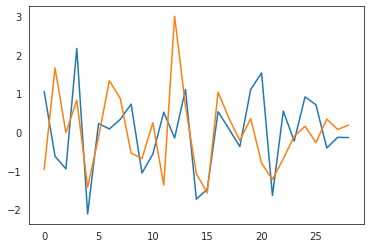

-3.8762096980447276e-17 0.9999999999999998 -2.2970131543968756e-17 1.0000000000000002


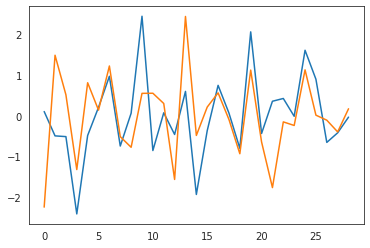

7.656710514656252e-18 0.9999999999999999 -1.0527976957652346e-17 0.9999999999999999


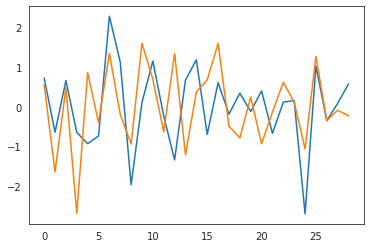

-1.3399243400648442e-17 0.9999999999999999 1.9620320693806645e-17 1.0


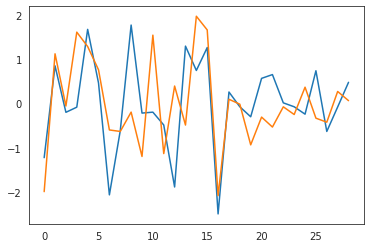

-1.914177628664063e-17 0.9999999999999999 6.125368411725002e-17 1.0000000000000002


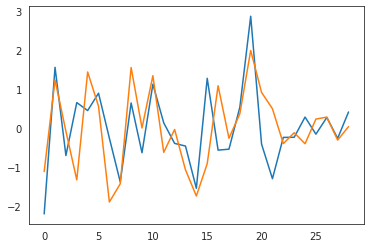

3.3498108501621104e-18 0.9999999999999998 -6.245004513516506e-17 0.9999999999999999


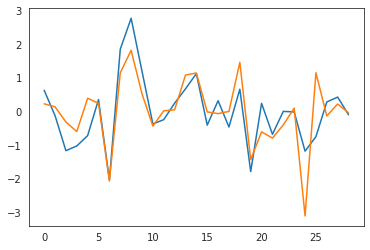

3.254101968728907e-17 1.0 5.144352377034669e-17 1.0


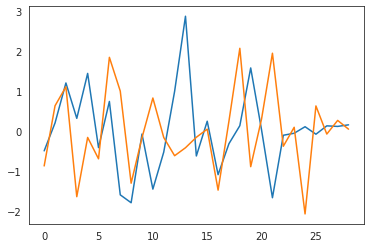

-2.2970131543968756e-17 0.9999999999999999 1.914177628664063e-18 1.0


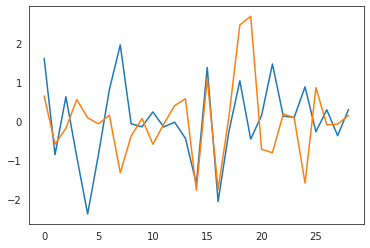

-2.488430917263282e-17 0.9999999999999998 -2.871266442996095e-17 1.0


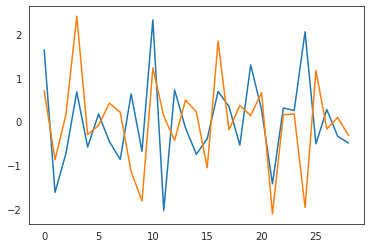

In [355]:
components = np.zeros((len(shared_regions), *atlas.shape))

# wa_norm = sk_normalize(output['wa'], axis=0)
# wb_norm = sk_normalize(output['wb'], axis=0)

wa_norm = zscore(output['wa'], axis=0)
wb_norm = zscore(output['wb'], axis=0)


for c in range(len(shared_regions)):
    # ca = output['wa'][:, c].copy()
    # cb = output['wb'][:, c].copy()
    
    ca = wa_norm[:, c]
    cb = wb_norm[:, c]

    print(ca.mean(), ca.std(), cb.mean(), cb.std())
    plt.plot(ca)
    plt.plot(cb)

    plt.show()
    
    for i in range(len(shared_regions)):
        region_id = list(regions_r.keys())[i]
        components[c][load['atlas'] == region_id] = ca[i]
        
        region_id = list(regions_l.keys())[i]
        components[c][load['atlas'] == region_id] = cb[i]

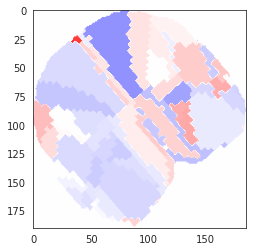

In [401]:
plt.imshow(components[0], vmin=-5, vmax=5, cmap='bwr')

In [380]:
np.linalg.norm(wa_norm, axis=1)

array([7.38845883, 7.26071316, 3.98284522, 5.65523574, 6.93337815,
       3.89865665, 5.71517212, 5.34551632, 5.28920848, 4.61245744,
       4.69033428, 2.77945309, 3.15169878, 4.8400004 , 6.07358809,
       5.84035432, 5.07517128, 1.42751384, 5.9190813 , 6.8231915 ,
       3.79345406, 5.26732582, 3.69929946, 2.89302128, 8.0428151 ,
       8.57580559, 6.12908957, 4.52059718, 2.86321358])

In [381]:
wa_norm.max()

3.491459557784996

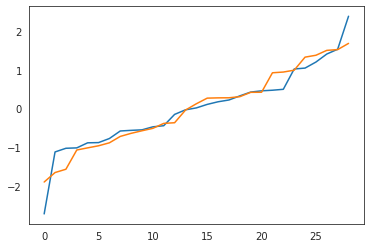

In [408]:
plt.plot(sorted(wa_norm[:, 1]))
plt.plot(sorted(wb_norm[:, 1]))

### ICA

In [419]:
from sklearn.decomposition import FastICA

In [420]:
ica_r = FastICA().fit(x_r)
ica_l = FastICA().fit(x_l)

In [421]:
ica_r.components_.shape

(29, 29)

-5.742532885992189e-18 1.0 -3.828355257328126e-17 1.0


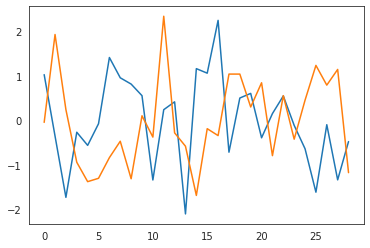

7.752419396089455e-17 1.0 7.656710514656252e-18 1.0


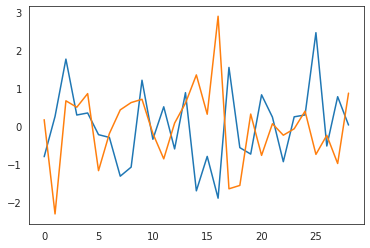

1.2322518484524904e-16 1.0 1.3399243400648442e-17 1.0000000000000002


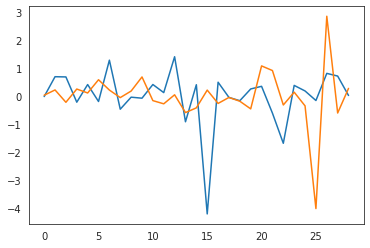

-7.656710514656252e-18 0.9999999999999998 2.6798486801296883e-17 1.0


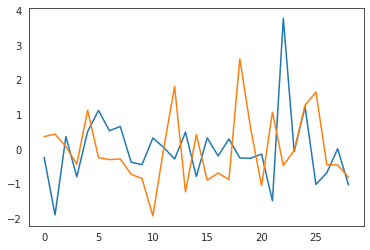

-4.4504629866439464e-17 1.0000000000000002 5.74253288599219e-17 1.0


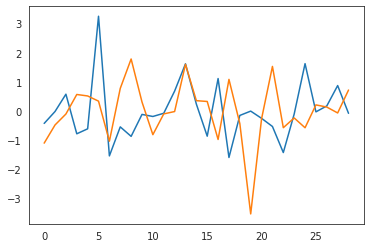

-7.656710514656252e-18 1.0 3.828355257328126e-18 0.9999999999999999


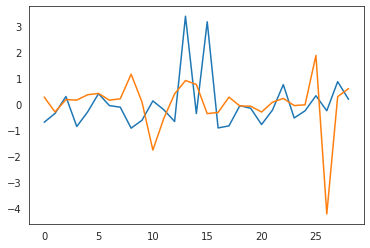

-1.5313421029312504e-17 1.0 -5.729073824540645e-17 0.9999999999999998


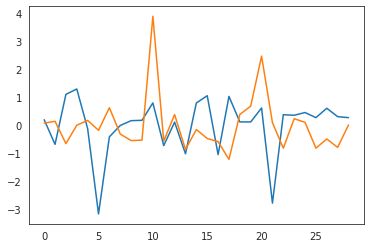

-3.6369374944617196e-17 1.0 -2.6798486801296883e-17 0.9999999999999999


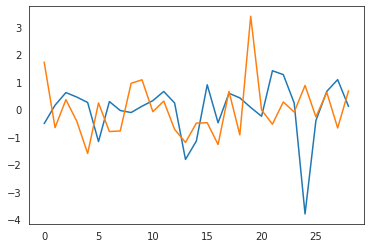

7.656710514656252e-18 0.9999999999999999 -1.914177628664063e-18 0.9999999999999999


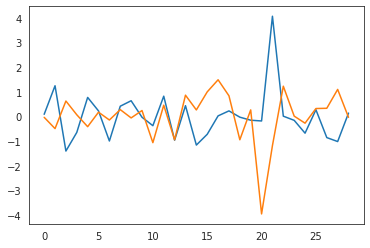

1.914177628664063e-18 1.0 -1.5313421029312504e-17 1.0


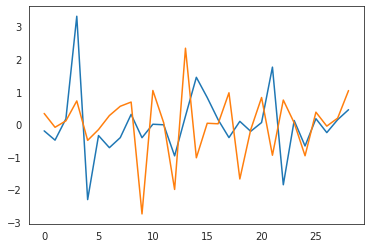

-1.914177628664063e-17 0.9999999999999999 -1.1485065771984378e-17 1.0


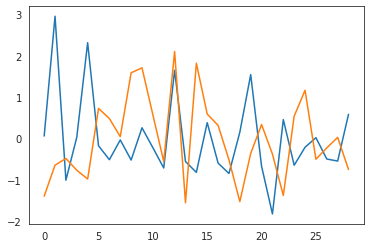

2.9669753244292974e-17 0.9999999999999999 1.3877787807814457e-17 0.9999999999999999


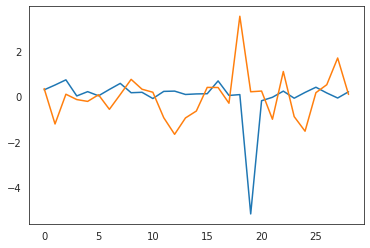

-3.230174748370606e-17 0.9999999999999999 -7.465292751789846e-17 1.0


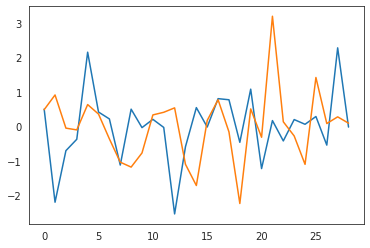

8.039546040389065e-17 0.9999999999999999 -3.828355257328126e-17 0.9999999999999999


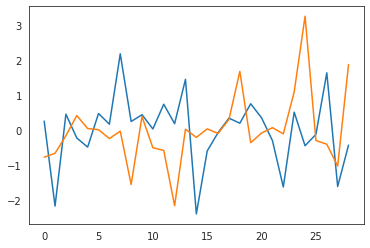

-2.8712664429960945e-18 0.9999999999999999 3.828355257328126e-18 1.0


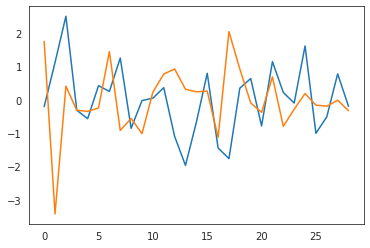

-1.2681426789899418e-17 1.0 -3.828355257328126e-17 1.0


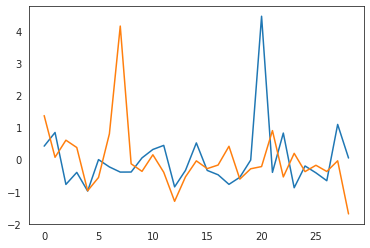

2.6798486801296883e-17 0.9999999999999999 -3.732646375894923e-17 1.0


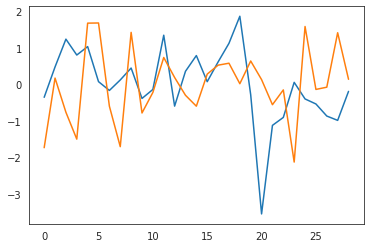

7.656710514656252e-18 1.0 -4.5461718680771495e-18 1.0


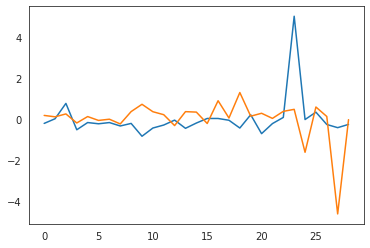

6.99871195480298e-18 1.0 -4.785444071660157e-19 0.9999999999999999


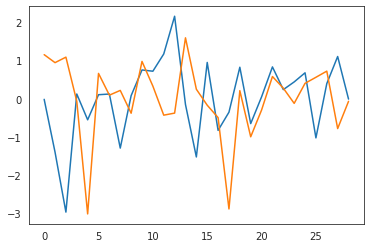

-4.785444071660158e-18 1.0 -4.0197730201945323e-17 1.0


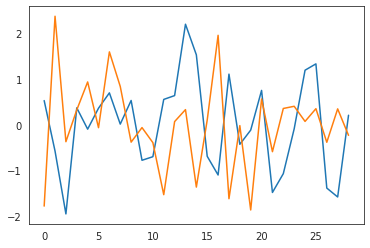

5.772441911440065e-18 0.9999999999999999 -3.828355257328126e-17 0.9999999999999999


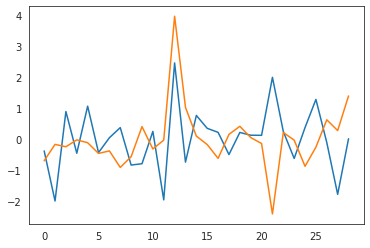

3.062684205862501e-17 1.0 -4.0197730201945323e-17 1.0


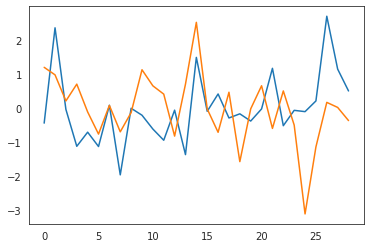

1.1485065771984378e-17 1.0 -6.125368411725002e-17 0.9999999999999999


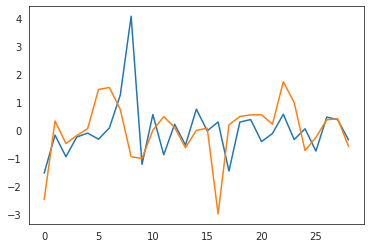

-6.125368411725002e-17 0.9999999999999999 -4.594026308793751e-17 0.9999999999999998


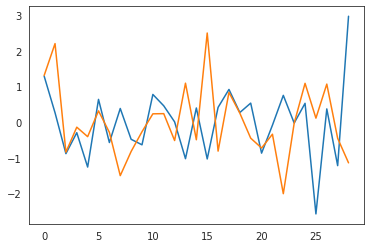

-6.125368411725002e-17 1.0 4.6897351902269545e-17 1.0


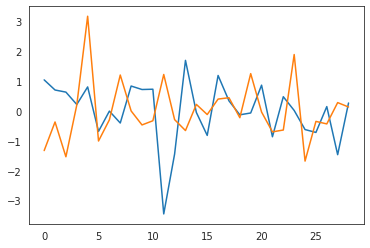

3.828355257328126e-18 1.0 5.551115123125783e-17 1.0


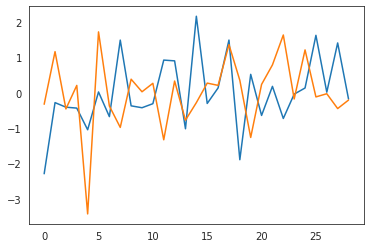

1.8184687472308598e-17 1.0 9.570888143320316e-18 1.0


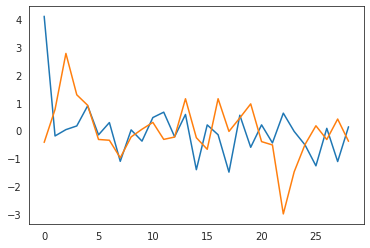

-4.1154819016277357e-17 1.0000000000000002 3.828355257328126e-18 1.0000000000000002


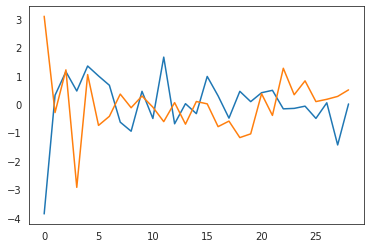

2.584139798696485e-17 1.0 2.0098865100972662e-17 1.0


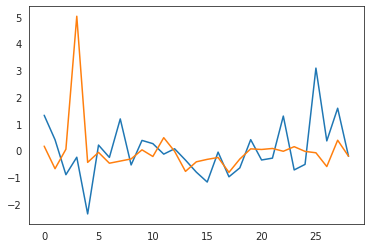

In [422]:
components = np.zeros((len(shared_regions), *atlas.shape))

wa_norm = zscore(ica_r.components_, axis=0)
wb_norm = zscore(ica_l.components_, axis=0)

for c in range(len(shared_regions)):
    # ca = output['wa'][:, c].copy()
    # cb = output['wb'][:, c].copy()
    
    ca = wa_norm[:, c]
    cb = wb_norm[:, c]

    print(ca.mean(), ca.std(), cb.mean(), cb.std())
    plt.plot(ca)
    plt.plot(cb)

    plt.show()
    
    for i in range(len(shared_regions)):
        region_id = list(regions_r.keys())[i]
        components[c][load['atlas'] == region_id] = ca[i]
        
        region_id = list(regions_l.keys())[i]
        components[c][load['atlas'] == region_id] = cb[i]

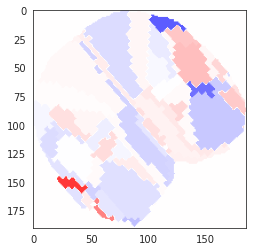

In [430]:
plt.imshow(components[6], vmin=-5, vmax=5, cmap='bwr')

In [434]:
x = df_clean.values.copy()
x.shape

(66000, 59)

In [435]:
ica = FastICA(n_components=20).fit(x)

In [437]:
ica.components_.shape

(20, 59)

In [440]:
components = np.zeros((len(shared_regions), *atlas.shape))

for c in range(ica.components_.shape[0]):
    for i in range(ica.components_.shape[1]):
        region_id = list(atls_org['regions'].keys())[i]
        components[c][load['atlas'] == region_id] = ica.components_[c, i]

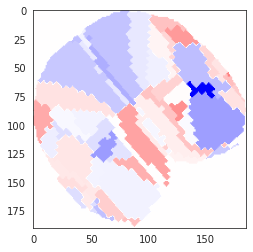

In [465]:
x2plt = components[17]
vminmax = np.max(np.abs(x2plt))
plt.imshow(x2plt, cmap='bwr', vmin=-vminmax, vmax=vminmax)

In [382]:
graphs = {th: nx.from_numpy_matrix(a) for th, a in corrs['spearman'].items()}

In [383]:
results_louvain = run_louvain(graphs[0.8], res=np.logspace(-0.3, 0.3, 1001))

  0%|          | 0/1001 [00:00<?, ?it/s]

In [384]:
from importlib import reload
from utils import plotting
reload(plotting)

from utils.plotting import *

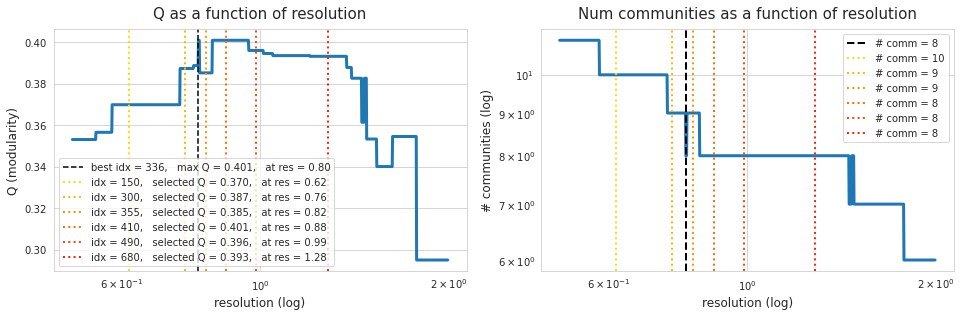

In [397]:
selected_idxs = [150, 300, 355, 410, 490, 680]
fig, axes = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

In [27]:
# fig.savefig('Louvain_results{:d}.pdf'.format(num_regions), dpi=300, bbox_inches='tight')

In [398]:
def plot_louvain_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    contour: np.ndarray,
    modularities: dict,
    selected_idxs: list,
    pearson_th: float = 0.8,
    spearman_th: float = 0.7,
    figsize=(12, 4.5),
    colorbar=False, ):

    x0, y0 = tuple(zip(*modularities.items()))
    best_idx = np.argmax(y0)
    best_res = x0[best_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [best_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        # pearson
        g = nx.from_numpy_matrix(pearson[pearson_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)

        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[0, ii].imshow(data2plot, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[0, ii].set_title(msg, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[spearman_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)
    
        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[1, ii].imshow(data2plot, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[1, ii].set_title(msg, y=1.03)
        

        if ii == 0:
            axes[0, ii].set_ylabel('pearson\n(th = {:.2f})\n'.format(pearson_th), fontsize=12)
            axes[1, ii].set_ylabel('spearman\n(th = {:.2f})\n'.format(spearman_th), fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes

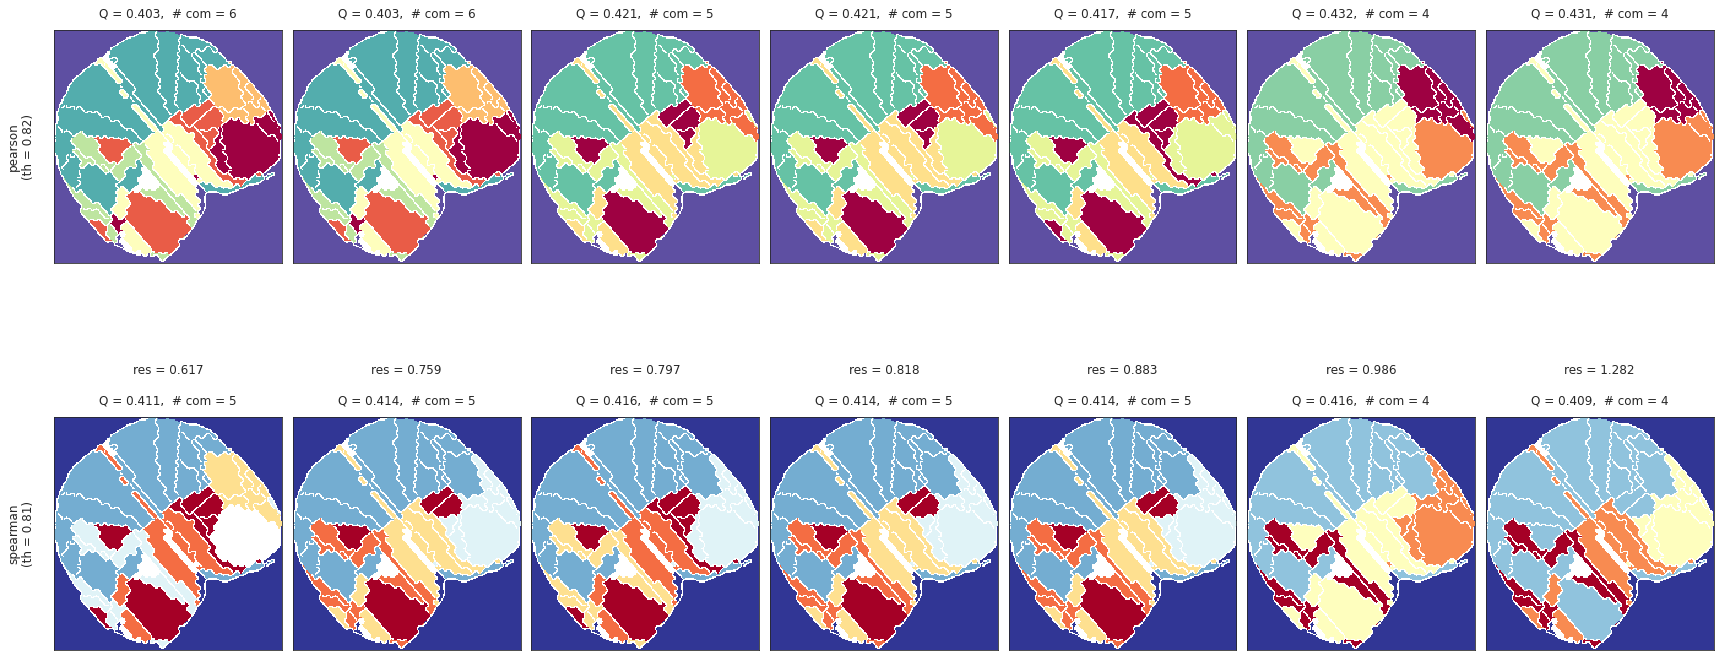

In [400]:
# selected_idxs = [450, 540, 585, 680] # [440, 520, 530, 590]

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.82,
    spearman_th=0.81,
    figsize=(24, 12),
    colorbar=False, )